# Q-learning with neural networks

In [35]:
# a few packages we need to import
%matplotlib notebook
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 

import torch

import pendulum

The goal of this homework is to implement the Q-learning with a neural network for the Q function to solve the inverted pendulum problem.

<img src='pendulum.png' width="120">

In the following, we write $x = \begin{pmatrix} \theta \\ \dot{\theta} \end{pmatrix}$ as the vector of states of the system.

## System dynamics
* The system dynamics is implemented in the `pendulum.py` function. The dynamics is implemented in `pendulum.step`.
* The allowed control inputs are $[-5,0,5]$

## Cost function
The goal is to find a policy that minimizes the following cost
$$\min \sum_{n=0}^N \alpha^n g(x,u)$$
where
$$g(x,v,u) = 0.01*(1-\cos(x-\pi))^2 + 0.001* v^2 + 0.00001*u^2$$
which gives a high cost for states far from $\pi$ (i.e. far from the inverted position) or states with non zero velocity or high controls



## Q-learning algorithm to implement
For each episode:
* Initialize the episode $x_0 = [0,0]$
* For each step of the episode:
    * Select $u_n$ using an $\epsilon$-greedy policy
    * Compute the next state $x_{n+1}$
    * Compute the target $y_n = g(x_n,u_n) + \alpha \min_a Q(x_{n+1},a)$
    * Do one SGD step on the neural network parameters to minimize $(Q(x,u) - y_t)^2$


## Parameters:
* Episode length 100 steps
* Discount factor $\alpha = 0,99$
* Learning rate (for SGD) 0.1
* $\epsilon = 0.1$



## Using PyTorch
You need to install and use PyTorch for the neural network and do the optimization. 

You may want to use the following functions:
* [`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* [`torch.nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

The neural network is given below

In [36]:
## we define the neural network to be used for Q-learning
## 2 hidden layers with 64 nodes
## 2 inputs (state)
## 3 outputs for the 3 possible controls
D_in, H, D_out = 2, 64, 3

q_function = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out)
)

## we initialize the network parameters to 0
for params in q_function.parameters():
    params = torch.zeros_like(params)


### possible controls
possible_controls = np.array([-5.,0.,5.])

# Questions:
1. Implement the Q-learning algorithm described above
2. Test that it works with and without pushes using the code below
3. Plot the cost per episode (to visualize learning)
4. Plot the learned value function (in 2D as a function of pendulum position and velocity) as well as the policy.
5. Describe the algorithm and put the plots in a short report (max 2 pages) and include a video of the pendulum.

In [37]:
def g(x, u):
    position = x[0]
    velocity = x[1]

    return 0.01 * (1 - torch.cos(position - torch.tensor(np.pi)))**2 + \
           0.001 * velocity**2 + \
           0.00001 * (torch.tensor(u)**2)


In [ ]:
import random


num_episodes = 1000
episode_length = 100
discount_factor = 0.99    # Discount factor alpha
epsilon = 0.1


# Initialize all network parameters to zero
for param in q_function.parameters():
    param.data.zero_()
# for param in q_function.parameters():
#     if param.dim() > 1:  # For weights
#         torch.nn.init.xavier_uniform_(param)
#     else:  # For biases
#         torch.nn.init.zeros_(param)

# Define optimizer and loss function
learning_rate = 0.1
optimizer = torch.optim.SGD(q_function.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss()

costs = []

# Training Loop

for episode in range(num_episodes):
    state = np.array([0.0, 0.0])
    
    episode_cost = 0.0

    for step_num in range(episode_length):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Shape: [1, 2]
        
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            action = np.random.choice(possible_controls)
        else:
            with torch.no_grad():
                q_values = q_function(state_tensor)  # Shape: [1, 3]
                min_index = torch.argmin(q_values, dim=1).item()
                action = possible_controls[min_index]
        
        # Take action and observe the next state
        next_state = pendulum.step(state, action)  # Should return a numpy array [x_next, v_next]
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)  # Shape: [1, 2]
        
        with torch.no_grad():
            # Compute the cost g(x_n, u_n)
            cost = g(torch.tensor(state, dtype=torch.float32), action)
            episode_cost += cost.item()
            print(f"Cost: {cost.item()}")

            # Compute the minimum Q-value for the next state
            q_next = q_function(next_state_tensor)  # Shape: [1, 3]
            min_q_next = torch.min(q_next, dim=1)[0]  # Shape: [1]
            
            # Compute the target
            target = cost + discount_factor * min_q_next  # Shape: [1]
            print(f"Target: {target.item()}")
        
        # Compute the current Q-value for the state
        q_values = q_function(state_tensor)  # Shape: [1, 3]
        action_index = list(possible_controls).index(action)
        min_q_curr = q_values[0, action_index]
        print(f"Q-value: {min_q_curr.item()}")

        # Compute the loss (MSE between Q-value and target)
        loss = loss_fn(min_q_curr, target)
        print(f"Loss: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the state
        # correlation though, may use DQP
        state = next_state

    costs.append(episode_cost)
    
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{num_episodes} completed.")

print("Training completed.")

/home/zhiquancao/miniconda3/envs/rl/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 100/1000 completed.
Episode 200/1000 completed.
Episode 300/1000 completed.
Episode 400/1000 completed.
Episode 500/1000 completed.
Episode 600/1000 completed.
Episode 700/1000 completed.
Episode 800/1000 completed.
Episode 900/1000 completed.
Episode 1000/1000 completed.
Training completed.


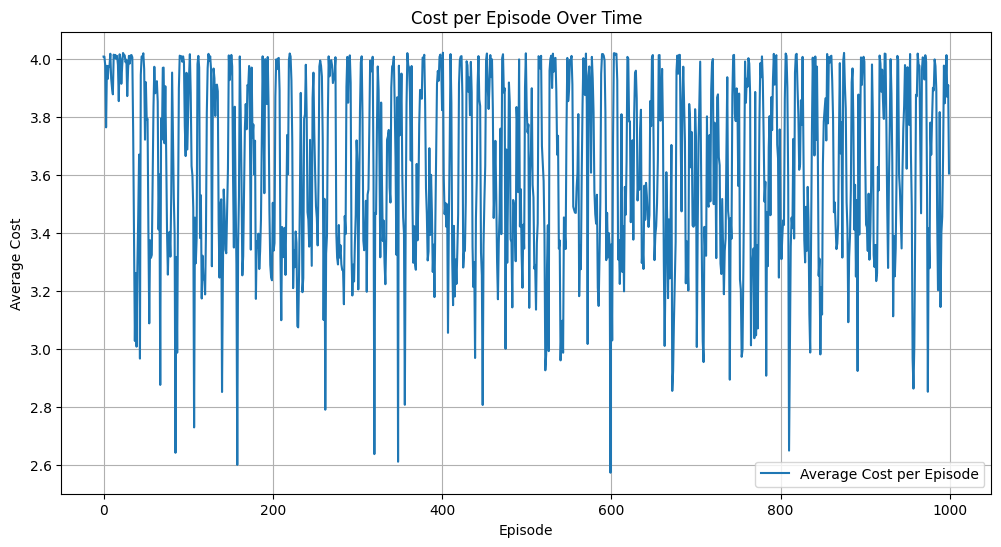

In [63]:
# Plotting the Cost per Episode
%matplotlib inline

plt.figure(figsize=(12, 6))
plt.plot(costs, label='Average Cost per Episode')
plt.xlabel('Episode')
plt.ylabel('Average Cost')
plt.title('Cost per Episode Over Time')
plt.legend()
plt.grid(True)
plt.show()


[[3.5865767 3.5865767 3.5865767 ... 3.5865767 3.5865767 3.5865767]
 [3.5865767 3.5865767 3.5865767 ... 3.5865767 3.5865767 3.5865767]
 [3.5865767 3.5865767 3.5865767 ... 3.5865767 3.5865767 3.5865767]
 ...
 [3.5865767 3.5865767 3.5865767 ... 3.5865767 3.5865767 3.5865767]
 [3.5865767 3.5865767 3.5865767 ... 3.5865767 3.5865767 3.5865767]
 [3.5865767 3.5865767 3.5865767 ... 3.5865767 3.5865767 3.5865767]]


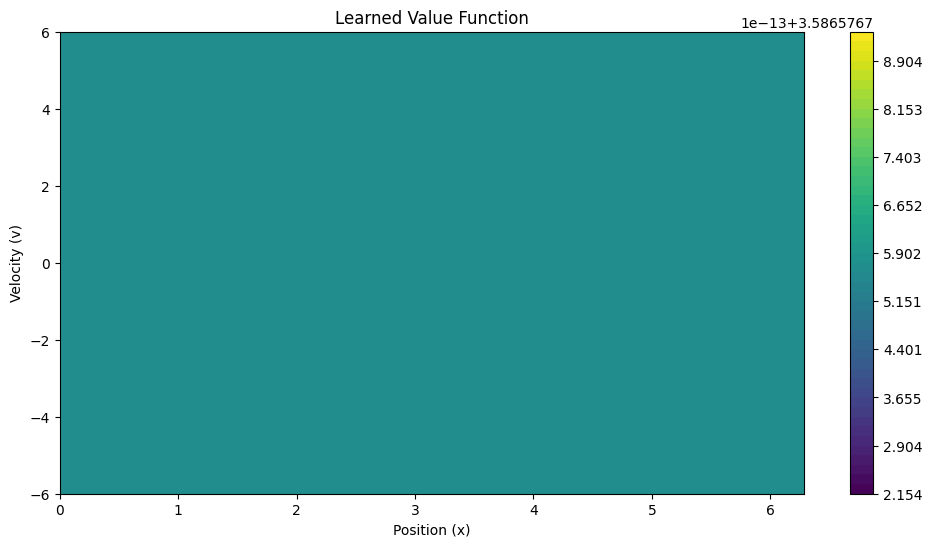

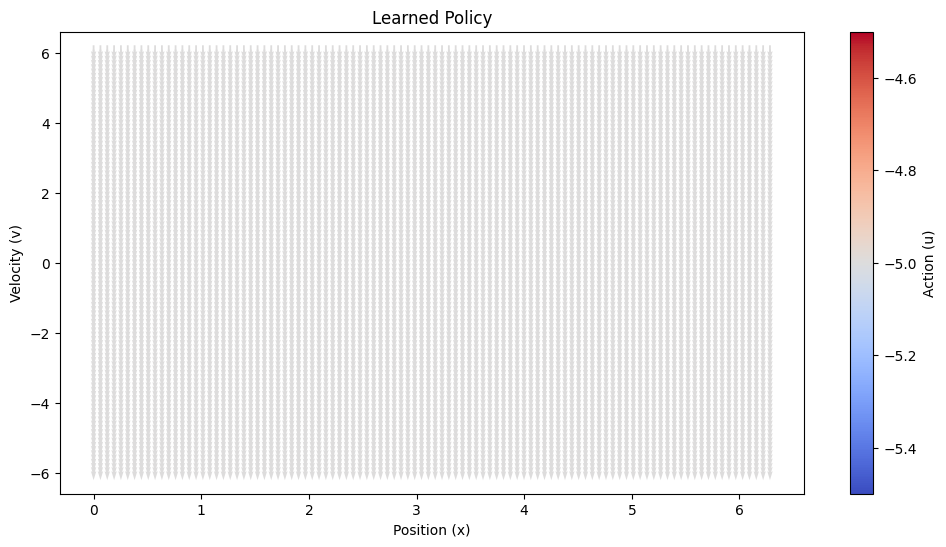

In [64]:

# Plotting the Learned Value Function and Policy
# Define a grid over the state space
num_x = 100  # Number of points for position
num_v = 100  # Number of points for velocity

x_vals = np.linspace(0, 2 * np.pi, num_x)
v_vals = np.linspace(-6.0, 6.0, num_v)
X, V = np.meshgrid(x_vals, v_vals)
positions = X.flatten()
velocities = V.flatten()
states = np.vstack([positions, velocities]).T  # Shape: [num_x*num_v, 2]

# Convert states to tensor
states_tensor = torch.tensor(states, dtype=torch.float32)

# Compute Q-values for all states
with torch.no_grad():
    q_values_all = q_function(states_tensor)  # Shape: [num_states, 3]

# Compute the minimum Q-value for the value function
min_q_values = torch.min(q_values_all, dim=1)[0].numpy()  # Shape: [num_states]

# Reshape to grid
Value_Function = min_q_values.reshape(num_v, num_x)
print(Value_Function)

# Compute the policy (action indices) for each state
policy_indices = torch.argmin(q_values_all, dim=1).numpy()  # Shape: [num_states]
policy = possible_controls[policy_indices]

# Reshape policy to grid
Policy = policy.reshape(num_v, num_x)

# Plot the Value Function
plt.figure(figsize=(12, 6))
cp = plt.contourf(X, V, Value_Function, levels=50, cmap='viridis')
plt.colorbar(cp)
plt.xlabel('Position (x)')
plt.ylabel('Velocity (v)')
plt.title('Learned Value Function')
plt.show()

# Plot the Policy
plt.figure(figsize=(12, 6))
# To visualize the policy, we can use quiver to show the action magnitude
# Here, we'll represent actions as arrows in the velocity direction
# First, compute the change in velocity due to action
# delta_v = integration_dt * (u - g * sin(x))
# We'll approximate the direction based on u
delta_v = (Policy - 0)  # Since u can be -5, 0, 5

# Normalize the arrows for better visualization
arrow_length = (delta_v) / 5.0  # Scale arrows

plt.quiver(X, V, np.zeros_like(arrow_length), arrow_length, Policy, cmap='coolwarm', pivot='middle', scale=50)
plt.xlabel('Position (x)')
plt.ylabel('Velocity (v)')
plt.title('Learned Policy')
plt.colorbar(label='Action (u)')
plt.show()

## Testing
You can test your results with the code below which use the Q-function to create a controller send to the `animate_robot` function.
You can choose to save also a movie of the animation and toggle the animation with a disturbance.

In [60]:
x0 = np.zeros((2,1))
def controller(x):
    u_pred = torch.argmin(q_function(torch.as_tensor(x, dtype=torch.float).unsqueeze(0))).item()
    u = possible_controls[u_pred]
    return u
    
pendulum.animate_robot(x0,controller,push=False, save_movie=True)


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAziFtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DRZliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOOM8Ue0I9hJLKvPs/l
qmb6oagJo7SFBr1OBuUCQQFG2xsmgmMN/KGNBIqjFM17HZsrECpFM2gzb3sRbGaX3YXhKCoBr2Vv
Btnz7czyXRN90c1rKBwG6h7+y1G9RctmKdYkNfZ9PIcL6+yDtJIOH1UIAuj9/wue2ZtEw6TSqBcK
L8eOssBoMcX7PXzJUsrbPviIbDjdWE10mfuw6TofcTbVsC7GFr0ZwVPYH+AOycAUFjmAGJk95XFX
RxCqPJz61rNvSkCKxJc2DnDq23y1nGBZ0W7xxqpU/igREKd8+qFqImDJ6q/ECIqJRDeL1+W9gvs0
B80Nn771qo1L6r8JJWhIyfsnvASOIfl+rVzNt0o2qwOxtlViXrpFGFdX+hJ/+A42nrNzSIvQobCb
1WYV+0aZtiJfPn6w1PvG4sdtX+BT8hpKEx+lGo4fw7gE1OQzWCRSf/UNjadsZRLvGuvYUKCdwTEk
WfopPqa1ddCsc1nlIPX5fys0H90Iqbz/qYO8ABZaIWjQvl/bvZyxMzeSWpapBIGfgt9jxS/GqcPn
5qzL5Crt5M3tXI70PXm9Vla/HVaCxgPICI9z6B9hJKucXbnulv0Tx3pgWGkq4zCJoUSDQbMTKpHP
1+uP9z8QZom84f5DU6BeXVvtHm4djF23BlQKdhX2EUStmmG6N08XGoAVuMW72rKKVN6VdHRgsHNr
x3MR4qDMgAxERdUoQ7BXRJr4BX5soPZq/wcjolq6sTi1OvLDBtyBLPszN6tiPcUaMheYx0iV67aE
zZf/BUqm/lhAt8bzKYdsJ9/lcztqCxibPrNj5oyGn3C0REKARQj2zVOcjGQ+FMzZO2661ZGQyDFz
iir12w0bCCrErPPWnwawwtU4EcDyMcfy1O9nup++LMTj/9v5cGKwseLrqDKDLRy72SeWx0X1PS2r
gB5EoiitXz2syX3fZtL7eXGNp9LGfmQZvNn/8kQNYLyikrHwFtnL/NwLzzF1wqLYpRm7lnQcAK08
DUly7RKGunCX7cfEaLO2YLdetEUtN+WGIMUegtlA0WxNBo4/aPhcbdhXK0nhVZKAO7NT/QAL/+Yx
5BkLt8cfKDySgqLF75BgIOUJh0ib2PPpoocKe2KEjR7SCjS2rxPtgBk2EXdhJD5Q2wXu/c9rCths
1jSEGuSqEwVxO7GbN19+LNdEa9TvZlhcscfGQcr0yhOHKsmiGhqJXqcixubXTLuyPWkcX7k2y2mk
SmFv+M3h7BW8F8KyBtq+Susbt7S0KcrnNmgI7a59R9NBWHNU2bzFf8MQL0DbBmYb3ZYdYDlj1z7H
2Qf+Sp7Me+IA72yWlBvkbG+q5OnsXciOKIm/0kDkHxZKVyTv6H2zwetzn8NnvSF1gPu4vS2WLrv7
2U+rltICVC7VC3WxB1hTBYYE1Lp9R29nUfzXI2ZIwpP5I2Q9qUshCM4UEoAYsFNuMuD0FyW4qrs5
E8PRrLfmd1SyZMcr3n9XEsCMtontispemBQdHTxb/4FbJhxL54BcaLXTMdcX+QYoVEuEwWDQB4wT
m/Mw1dlin5dv0BbH7re+L4UNFAgSi+MIAtlSWemYp+mstcRpTRfyAm4qtIezzxb43jyvwegmn5TB
mYM1S754IszNpkzWfJO35GkeBkLqCHecUcUxppAaniflhl0b4zZvXB49h0YVBtIupg46TPRRBqKt
kfTq+8ke18pwTxext8PEg1lKK6ytvrQDWXPu8Nmvuz/inuts3LE49qjcrKukSBrYNCHgpiBHIu8Y
5ZuF2mK2wqzo5rRbTEXgbtSY3D0PNQkwbLGoKyAFlbJdUUb8xBcbFHF98KQHREtPcgBDmi05+pa2
9it9Kxv3wCSOfJ6Nz2jz+Q9/zRZsRs0ZA9rKSmC0TjkJcwskKhlJqGvYnBvpPiYu9Ui7Ktk7YL0x
rCOw3gEzQ++p4GVEgmiyclFawgFDcC0zbKOmR6IJ2aFIenenrYQ/H6uQdO5vNy0NBu2gsMwA5td5
On9X0t/n2noRv8Cs3kULowhneeFjNnfecbTih8b/DwQ2/MEhUNzuGyab7hudaEz+7c1BVsFaCNPf
SY5d6jZ5jBIStCHvGFP7PClVALGVymqF4iFGWb4UkiKKsCLmOurLR0mdeGeM/tSCVRUV5d+Xqw7u
+sp9/vi+fNEbFU46h3YPfToqdqwwnM/9Kpir2NYUwNwBHW9G9dw7BxtA0btlu9/RoMaiQ8STaA8C
qT8jgvL/X52bVgwdOIhUxaLScZRX8wlDZQC11pyAACIDauejbJPFrTc8eaqZzGYO23PP4I/ZvlGF
cujBL7LsIFsbP/a8+vjTw3zN91FxZkGFtvHx68M+Yao/Q/LjytYKh953oi9WvwgFYOcCqY2PRxB4
p62LlRLF0a0KgVmQZWxJWN8r7GavR36pvCQ/7N8vwR376fuI/JA6BdtWd62Fh/a6/cf8YvgBBzLJ
QPoWK/GMoPZH/nQQe4Tk991mV3nHSedggrwatgv5gRExpBa7nLt4E3hlDZ7H9M5jKqNVsfMF5+bm
8NX/56YlxMqkysVNt7TmC7gnStRq7rIYJnGlkSQ+FcgtBSpwGAMlSBSPFPUP4xG61FGZ1BueSN8f
xaGTynwLc6cKevoVtI6OFf/VO10bA8Xw6CqZL6dseNwE/kt/Zit+cQdIV+JhRXCfTF6RQGn6p8PS
aS8fQJ9TCVmMj5NpZOZt4E1OQzGs5a7/g1XOTnyFaswmKhG6s3qEH0Mk2u6zbCgsqFNl654+6qtB
rFLutbNgOrd/uBl/W5qlM